# 19. Clustering

- Clustering is an example of unsupervised learning, in which we work with completely unlabeled data

- A data set showing where millionaires live probably has clusters in places like Beverly Hills and Manhattan.
- A data set showing how many hours people work each week probably has a cluster around 40 and another cluster right around 20.
- The clusters won’t label themselves. You’ll have to do that by looking at the data underlying each one.


## The Model
- Each input will be a vector in d-dimensional space
- Goal will be to identify clusters of similar inputs and (sometimes) to find a representative value for each cluster.


### K-means

- k is the number of clusters chosen in advance.
- We want to find k clusters minimizing the total sum of squared distances from each point to the mean of its assigned cluster.
- Finding an optimal clustering is a very hard problem.
- Iterative algorithm that usually finds a good clustering:
    1. Start with a set of k-means, which are points in d-dimensional space.
    2. Assign each point to the mean to which it is closest.
    3. If no point’s assignment has changed, stop and keep the clusters.
    4. If some point’s assignment has changed, recompute the means and return to step 2.



In [1]:
from linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [1]:
class KMeans:
    """performs k-means clustering"""
    
    def __init__(self, k):
        self.k = k # number of clusters
        self.means = None # means of clusters
    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))
    def train(self, inputs):
        self.means = random.sample(inputs, self.k)
        assignments = None
        while True:

            # Find new assignments
            new_assignments = list(map(self.classify, inputs))
          
            # If no assignments have changed, we're done.
            if assignments == new_assignments:
                return
            elif assignments == None:
                aasignments = new_assignmentsd
                continue
            # Otherwise keep the new assignments, assignments = new_assignments
            
            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = vector_mean(i_points)

In [14]:
 def fit(self, X, y=None, sample_weight=None):
        """Compute k-means clustering.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster. It must be noted that the data
            will be converted to C ordering, which will cause a memory
            copy if the given data is not C-contiguous.
            If a sparse matrix is passed, a copy will be made if it's not in
            CSR format.
        y : Ignored
            Not used, present here for API consistency by convention.
        sample_weight : array-like of shape (n_samples,), default=None
            The weights for each observation in X. If None, all observations
            are assigned equal weight.
            .. versionadded:: 0.20
        Returns
        -------
        self
            Fitted estimator.
        """
        random_state = check_random_state(self.random_state)

        if self.precompute_distances != 'deprecated':
            warnings.warn("'precompute_distances' was deprecated in version "
                          "0.23 and will be removed in 0.25. It has no "
                          "effect", FutureWarning)

        if self.n_jobs != 'deprecated':
            warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
                          " removed in 0.25.", FutureWarning)
            self._n_threads = self.n_jobs
        else:
            self._n_threads = None
        self._n_threads = _openmp_effective_n_threads(self._n_threads)

        n_init = self.n_init
        if n_init <= 0:
            raise ValueError("Invalid number of initializations."
                             " n_init=%d must be bigger than zero." % n_init)

        if self.max_iter <= 0:
            raise ValueError(
                'Number of iterations should be a positive number,'
                ' got %d instead' % self.max_iter
            )

        X = self._validate_data(X, accept_sparse='csr',
                                dtype=[np.float64, np.float32],
                                order='C', copy=self.copy_x,
                                accept_large_sparse=False)
        # verify that the number of samples given is larger than k
        if _num_samples(X) < self.n_clusters:
            raise ValueError("n_samples=%d should be >= n_clusters=%d" % (
                _num_samples(X), self.n_clusters))

        tol = _tolerance(X, self.tol)

        # Validate init array
        init = self.init
        if hasattr(init, '__array__'):
            init = check_array(init, dtype=X.dtype.type, copy=True, order='C')
            _validate_center_shape(X, self.n_clusters, init)

            if n_init != 1:
                warnings.warn(
                    'Explicit initial center position passed: '
                    'performing only one init in k-means instead of n_init=%d'
                    % n_init, RuntimeWarning, stacklevel=2)
                n_init = 1

        # subtract of mean of x for more accurate distance computations
        if not sp.issparse(X):
            X_mean = X.mean(axis=0)
            # The copy was already done above
            X -= X_mean

            if hasattr(init, '__array__'):
                init -= X_mean

        # precompute squared norms of data points
        x_squared_norms = row_norms(X, squared=True)

        best_labels, best_inertia, best_centers = None, None, None

        algorithm = self.algorithm
        if algorithm == "elkan" and self.n_clusters == 1:
            warnings.warn("algorithm='elkan' doesn't make sense for a single "
                          "cluster. Using 'full' instead.", RuntimeWarning)
            algorithm = "full"

        if algorithm == "auto":
            algorithm = "full" if self.n_clusters == 1 else "elkan"

        if algorithm == "full":
            kmeans_single = _kmeans_single_lloyd
        elif algorithm == "elkan":
            kmeans_single = _kmeans_single_elkan
        else:
            raise ValueError("Algorithm must be 'auto', 'full' or 'elkan', got"
                             " {}".format(str(algorithm)))

        # seeds for the initializations of the kmeans runs.
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)

        for seed in seeds:
            # run a k-means once
            labels, inertia, centers, n_iter_ = kmeans_single(
                X, sample_weight, self.n_clusters, max_iter=self.max_iter,
                init=init, verbose=self.verbose, tol=tol,
                x_squared_norms=x_squared_norms, random_state=seed,
                n_threads=self._n_threads)
            # determine if these results are the best so far
            if best_inertia is None or inertia < best_inertia:
                best_labels = labels.copy()
                best_centers = centers.copy()
                best_inertia = inertia
                best_n_iter = n_iter_

        if not sp.issparse(X):
            if not self.copy_x:
                X += X_mean
            best_centers += X_mean

        distinct_clusters = len(set(best_labels))
        if distinct_clusters < self.n_clusters:
            warnings.warn(
                "Number of distinct clusters ({}) found smaller than "
                "n_clusters ({}). Possibly due to duplicate points "
                "in X.".format(distinct_clusters, self.n_clusters),
                ConvergenceWarning, stacklevel=2)

        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iter_ = best_n_iter
        return self

**You will implement the K-means algorithm as a numpy version**

#### **Example: Meetups**

- to choose meetup locations that make it convenient for everyone to attend

In [15]:
data = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[
-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[
-11,-6],[-25,-9],[-18,-3]]

In [16]:
# random.seed(1)
clusterer = KMeans(3)
clusterer.fit(data)
print("3-means:")
print(clusterer.cluster_centers_)

3-means:
[[ 18.33333333  19.83333333]
 [-15.88888889 -10.33333333]
 [-43.8          5.4       ]]


In [17]:
my_clusters = [clusterer.classify(p) for p in data]
colormap = 'bgrcmyk'
my_color = list(map(lambda i: colormap[i], my_clusters))
x, y = zip(*data)
plt.scatter(x, y, color=my_color)
xc, yc = zip(*clusterer.means)
plt.scatter(xc, yc, marker='s')
plt.axis('equal')
plt.show()

AttributeError: 'KMeans' object has no attribute 'classify'

In [8]:
random.seed(0)
clusterer = 

In [8]:
KMeans(

In [8]:
2)
clusterer.train(data)
print("2-means:")
print(clusterer.means)
my_clusters = [clusterer.classify(p) for p in data]
colormap = 'bgrcmyk'
my_color = list(map(lambda i: colormap[i], my_clusters))
x, y = zip(*data)
plt.scatter(x, y, color=my_color)
xc, yc = zip(*clusterer.means)
plt.scatter(xc, yc, marker='s')
plt.axis('equal')
plt.show()

TypeError: zip argument #2 must support iteration

### Choosing k
- Plot the sum of squared errors (between each point and the mean of its cluster) as a function of k
- Look at where the graph “bends”:

In [9]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))
    
    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))

ks = range(1, len(data) + 1)
errors = [squared_clustering_errors(data, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.show()

TypeError: zip argument #2 must support iteration

### **Example: Clustering Colors**
- Computer images can be represented as two-dimensional array of pixels, where each pixel is itself a threedimensional vector (red, green, blue) indicating its color.
- Creating a five-color version of the image then entails:
    1. Choosing five colors
    2. Assigning one of those colors to each pixel
- Partition the pixels into five clusters in red-green-blue space

In [ ]:
path_to_png_file = "image.png"
import matplotlib.image as mpimg
img = mpimg.imread(path_to_png_file)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
top_row = img[0]
top_left_pixel = top_row[0]

#### **NOTE: This might take a while**

In [10]:
red, green, blue, alpha = top_left_pixel
pixels = [pixel for row in img for pixel in row]
clusterer = KMeans(5)
clusterer.train(pixels) # this might take a while

NameError: name 'top_left_pixel' is not defined

In [11]:
def recolor(pixel):
    cluster = clusterer.classify(pixel) # index of the closest cluster
    return clusterer.means[cluster] # mean of the closest cluster

In [12]:
new_img = [[recolor(pixel) for pixel in row] for row in img]
# recolor this row of pixels
# for each row in the image

NameError: name 'img' is not defined

In [13]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

NameError: name 'new_img' is not defined

### **Bottom-up Hierarchical Clustering**
- An alternative approach to clustering is to “grow” clusters from the bottom up. We can do this in the following way:
    1. Make each input its own cluster of one.
    2. As long as there are multiple clusters remaining, find the two closest clusters and merge them.


- In order to merge the closest clusters, we need some notion of the distance between clusters.
    - We’ll use the **minimum distance** between elements of the two clusters, which merges the two clusters that are closest to touching (but will sometimes produce large chain-like clusters that aren’t very tight).
    - If we wanted **tight spherical clusters**, we might use the **maximum distance** instead, as it merges the two clusters that fit in the smallest ball.
    - Both are common choices, as is the **average distance**

In [29]:
leaf1 = ([10, 20],) # to make a 1-tuple you need the trailing comma
leaf2 = ([30, -15],) # otherwise Python treats the parentheses as parenthe

In [30]:
merged = (1, [leaf1, leaf2])

In [31]:
def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value 
                for child in get_children(cluster) 
                for value in get_values(child)]

In [17]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

In [18]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

In [19]:
def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]
   
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))
        
        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])
        
        # and add their merge
        clusters.append(merged_cluster)
        
    # when there's only one cluster left, return it
    return clusters[0]

In [20]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]
    
    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))
        
    # once we have enough clusters...
    return clusters

In [21]:
print("bottom up hierarchical clustering")

base_cluster = bottom_up_cluster(data)
print(base_cluster)

print()
print("three clusters, min:")
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))

bottom up hierarchical clustering
(0, [(1, [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]), (16, [([11, 15],), ([13, 13],)])]), (2, [(4, [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]), ([-34, -1],)]), (6, [(7, [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]), (13, [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]), ([-18, -3],)])]), (12, [([-13, -19],), ([-9, -16],)])])])])

three clusters, min:
[[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]]
[[19, 28], [21, 27], [20, 23], [26, 13]]
[[11, 15], [13, 13]]


In [23]:
three_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]

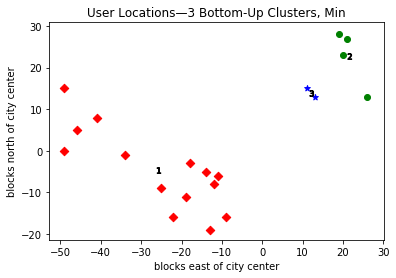

In [24]:
 for i, cluster, marker, color in zip([1, 2, 3],
                                      three_clusters,
                                      ['D','o','*'],
                                      ['r','g','b']):
    xs, ys = zip(*cluster) # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)
    
    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations—3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

In [25]:
print()
print("three clusters, max:")
base_cluster = bottom_up_cluster(data, max)
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))


three clusters, max:
[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]]
[[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]]
[[-11, -6], [-12, -8], [-14, -5], [-18, -3], [-22, -16], [-19, -11], [-25, -9], [-13, -19], [-9, -16]]


In [27]:
three_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]

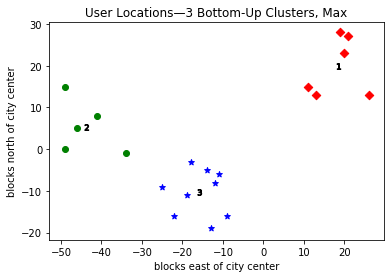

In [28]:
for i, cluster, marker, color in zip([1, 2, 3], three_clusters, ['D','o','*'], ['r','g','b']):

    xs, ys = zip(*cluster) # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)
 
    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations—3 Bottom-Up Clusters, Max")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()

In [29]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])

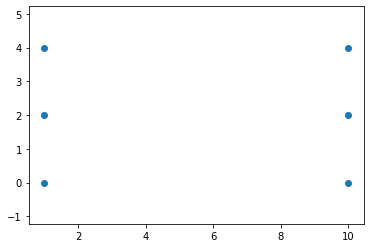

In [30]:
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')
plt.show()

In [32]:
kmeans = KMeans(n_clusters=2).fit(X)
kmeans.labels_

array([0, 0, 0, 1, 1, 1])

In [33]:
kmeans.predict([[0, 0], [12, 3]])

array([0, 1])

In [34]:
kmeans.cluster_centers_

array([[ 1.,  2.],
       [10.,  2.]])

### **Agglomerative Clustering in sklearn.cluster**
- linkage :
    - average uses the average of the distances of each observation of the two sets.
    - complete or maximum linkage uses the maximum distances between all observations of the two sets.
    - single uses the minimum of the distances between all observations of the two sets.


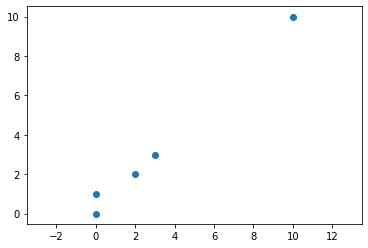

In [35]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0], [0, 1], [2, 2],[3,3], [10,10]])
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')
plt.show()

In [36]:
clustering = AgglomerativeClustering(n_clusters=2, linkage='average').fit(X)
clustering

AgglomerativeClustering(linkage='average')

In [37]:
clustering.labels_

array([0, 0, 0, 0, 1], dtype=int64)

### **Plot dendrogram**
y is a condensed distance matrix.
- A condensed distance matrix is a flat array containing the upper triangular of the distance matrix.
from sklearn.cluster import AgglomerativeClustering import numpy as np import matplotlib.pyplot as plt X = np.array([[0,0], [0, 1], [0, 3], [0,4], [0,5], [0,6], [3,0], [3,1]]) plt.scatter(X[:,0], X[:,1]) plt.axis('equal') plt.show()

In [59]:
from scipy.spatial.distance import pdist
y = pdist(X)

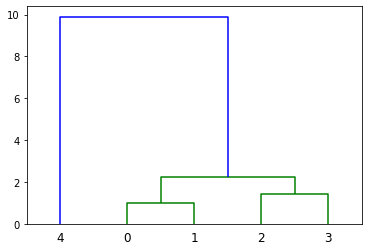

In [39]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
Z = hierarchy.linkage(y, 'single')
dn = hierarchy.dendrogram(Z)

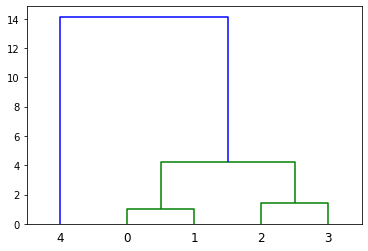

In [40]:
Z = hierarchy.linkage(y, 'complete')
dn = hierarchy.dendrogram(Z)

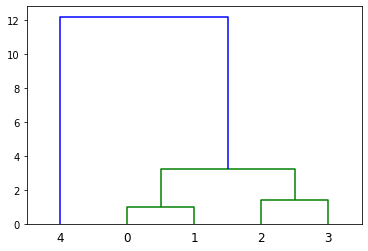

In [41]:
Z = hierarchy.linkage(y, 'average')
dn = hierarchy.dendrogram(Z)

In [2]:
from sklearn.cluster import KMeans


In [3]:
data= [[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]]

In [10]:
random.seed(0) # so you get the same results as me
# random.seed(1)
clusterer = KMeans(3)
clusterer.fit(data)
print("3-means:")
print(clusterer.cluster_centers_)

3-means:
[[ 1.  3.]
 [10.  2.]
 [ 1.  0.]]


In [13]:
clusterer.predict(data)

array([1, 2, 1, 0, 0, 0])

In [4]:
my_clusters = [clusterer.classify(p) for p in data]
colormap = 'bgrcmyk'
my_color = list(map(lambda i: colormap[i], my_clusters))
x, y = zip(*data)
plt.scatter(x, y, color=my_color)
xc, yc = zip(*clusterer.means)
plt.scatter(xc, yc, marker='s')
plt.axis('equal')
plt.show()

AttributeError: 'KMeans' object has no attribute 'train'